# Emulator: Calibration

## Setup

### Load Libraries

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from tqdm import tqdm

# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Splines
from statsmodels.regression.linear_model import yule_walker
from scipy.interpolate import CubicSpline
import pickle

# Custom imports
import functions.helper as hlp
import functions.siametadata as meta
import functions.emulator_func as em

### Set Paths

In [3]:
basepath = "/Users/quraus001/Documents/Uni/SIA-Sensitivity-Uncertainty/"

datapath = basepath + "data/"
plotpath = basepath + "plots/Emulator/"

save_plots = False

### Load Data

In [4]:
# CO2 Data
cmip6_ds = xr.open_dataset(datapath +"co2/CMIP6_co2_emissions_ssp.nc")
df_co2 = cmip6_ds.to_dataframe().cumsum(axis=0)
df_co2.index = df_co2.index.astype(int)

## Functions

In [5]:
names = {"sens":"Sensitivity", "true_slope":"Background slope",
         "ar1_corrcoef":"AR(1) coefficient $\phi_{in}$", 
         "num_members": "# of members", "var":"Variability", 
         "ar1":"AR(1) coefficient", "amplitude":"input variability $\sigma_{in}$ [m$^2$]"}

units = {"sens":"m$^2$/t", "var":"mio km$^2$", "ar1":""}

In [6]:
def create_boxplot(ax, values, xpos, width):

    bp = ax.boxplot(values, positions=[xpos], widths=[width], patch_artist=True)


    for patch in bp['boxes']:
        patch.set(facecolor = "#B1C9F5")

    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color ='navy')

    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker ='.',
                color ='#e7298a',
                alpha = 0.5)

## Calc Correction spines

In [7]:

def read_bias_both(loop_param, loop_values, box_param, noise="ar1",
                             num_members=100, ar1_corrcoef=0.4, amplitude=0.4, true_slope=-1.3, N=10,
                             start_year=1979, end_year=2024):
    """
    Function to analyze the emulator members by looping over one specified parameter.

    Parameters:
    - loop_param: str, the parameter to loop over ('num_members', 'true_slope', 'amplitude', or 'ar1_corrcoef')
    - loop_values: list or array of values to loop through
    - noise: str, type of noise
    - num_members: int, number of members (default value if not looping over this parameter)
    - ar1_corrcoef: float, AR1 correlation coefficient (default value if not looping over this parameter)
    - amplitude: float, amplitude (default value if not looping over this parameter)
    - true_slope: float, true slope (default value if not looping over this parameter)
    - N: int, number of iterations for each parameter value
    """
    
    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize=(3.5*1, 3), tight_layout=True)
    
    params = {
            "num_members": num_members,
            "noise": noise,
            "true_slope": true_slope,
            "amplitude": amplitude,
            "ar1_corrcoef": ar1_corrcoef,
            "intercept": 6.1,
            "start_year": start_year,
            "end_year": end_year,
            "dataframe": True,
            "df_co2": df_co2,
            "co2_name": "ssp245"
        }

    # Loop over the specified parameter
    Box_Means = []
    for value in tqdm(loop_values, leave=True):
        Mean = []

        # Update the parameter for the current loop
        params[loop_param] = value

        for _ in range(N):
            Data = []
            
            # Create synthetic time series
            df_dummy, Sensitivities = em.create_emulator_members(**params)

            
            for member in df_dummy.columns:
                sia = df_dummy[member].loc[start_year : end_year].values
                co2 = df_co2["ssp245"].loc[start_year : end_year].values
                sens, y_pred, lin_timing, intercept = meta.get_meta_data(sia, co2)
                residuals = df_dummy[member].loc[start_year:end_year] - y_pred

                # Recalculate Variability
                if box_param == "amplitude":
                    variability = np.std(residuals)
                    Data.append(variability)

                # Estimate AR parameters using Yule-Walker equations
                elif box_param == "ar1_corrcoef":
                    rho, sigma = yule_walker(residuals, order=1)
                    ar1_coef = rho[0] 
                    ar1_coef = ar1_coef + ((1+4*ar1_coef)/len(residuals)) # Kendal-Ord
                    Data.append(ar1_coef)

            Mean.append(np.mean(Data))

        create_boxplot(ax, Mean, value, loop_values[-1]/(len(loop_values)*2))
        Box_Means.append(np.mean(Mean))
    
    # Format Plot
    ax.axhline(y=amplitude, color="grey", linestyle="--")
    ax.set_xlabel("AR(1) coefficient $\phi_{in}$")

    diff = loop_values[1] - loop_values[0] 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(loop_values[0] - diff*0.75, loop_values[-1] + diff*0.75)
    
    ax.set_xticks(loop_values[::2],loop_values[::2])
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x:.1f}"))
    
    return fig, ax, Box_Means

### Standard Deviation

number of read_bias calls: 16


100%|██████████| 19/19 [1:45:06<00:00, 331.95s/it]  


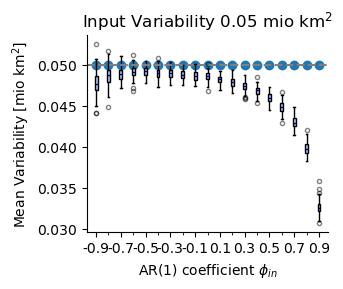

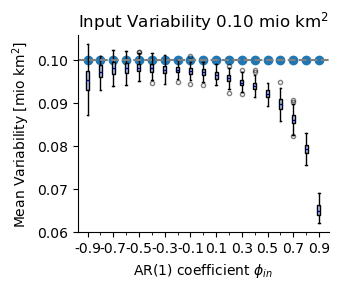

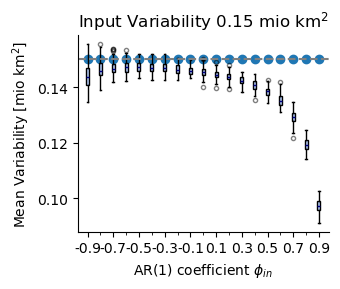

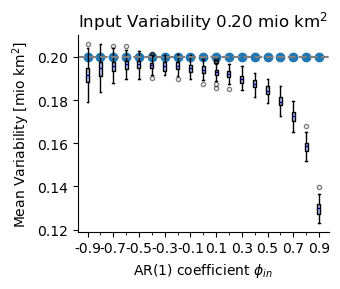

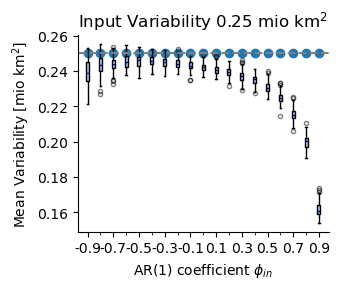

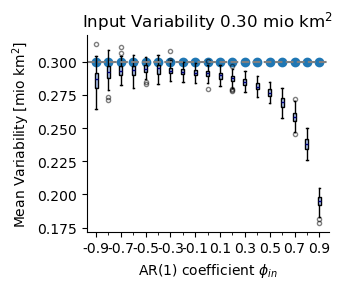

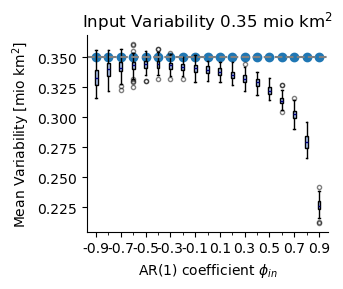

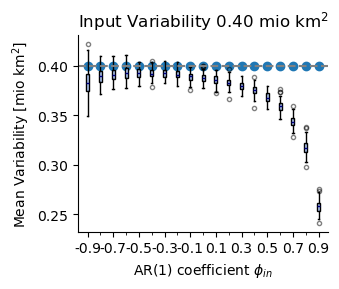

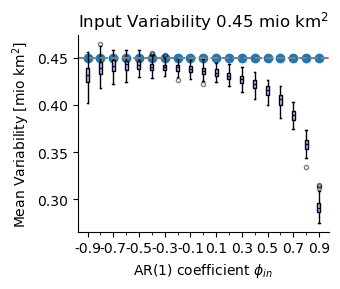

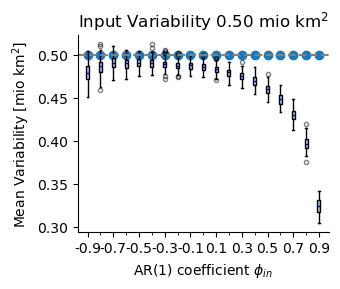

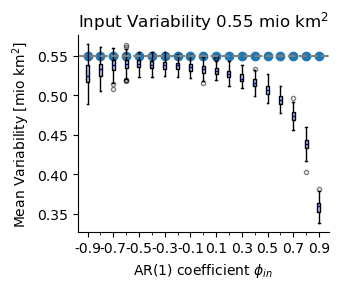

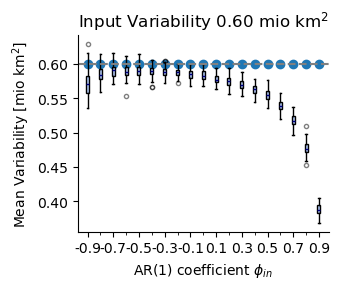

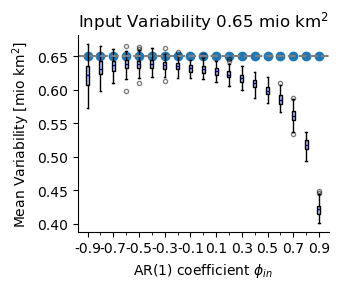

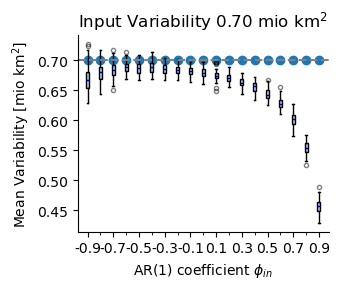

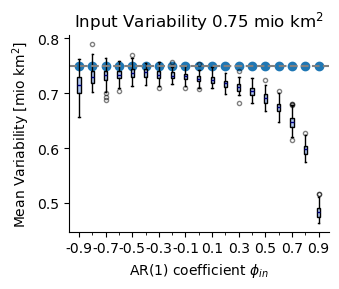

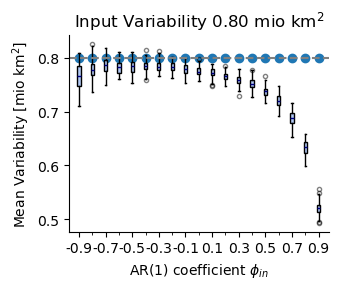

In [11]:
start, stop = 1979, 2020
ar1_values = np.arange(-0.9, 1, 0.1)#0.05
sigma_values = np.arange(0.05, 0.85, 0.05) #(0.85, 1.35, 0.05): 

print(f"number of read_bias calls: {len(sigma_values)}")

for sigma in sigma_values: 
    fig, ax, Box_Means = read_bias_both(loop_param='ar1_corrcoef', loop_values=ar1_values, box_param="amplitude", N=100, noise="ar1", 
                                        num_members=100, start_year=start, end_year=stop, amplitude=sigma)
    ax.set_ylabel(f"Mean Variability [mio km$^2$]")
    ax.set_title(f"Input Variability {sigma:.2f} mio km$^2$")

    # Get spline fit
    x = ar1_values
    y = np.array(Box_Means)
    Y = sigma-y

    spline = CubicSpline(x,Y)

    y_corrected = spline(x)

    ax.scatter(x, Box_Means + y_corrected)
    #fig.show()

    # Save the spline object
    with open(f"{datapath}/splines/sigma/spline_sigma_{sigma:1.2f}_T_{stop - start +1}.pkl", 'wb') as f:
        pickle.dump(spline, f)


### Autocorrelation

100%|██████████| 19/19 [00:50<00:00,  2.66s/it]


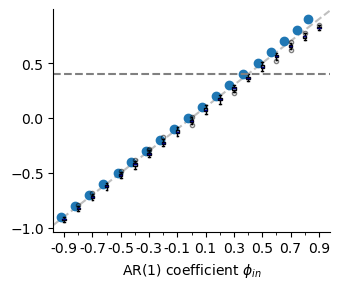

In [17]:
ar1_values = np.arange(-0.9, 1, 0.1)#0.05
Timeperiods = [[1979, 2024]]#, [1979, 1995], [1979, 2000], [1979, 2005], [1979, 2010], [1979, 2015], [1979, 2020]]

for timeperiod in Timeperiods[:]:
    start, stop = timeperiod

    fig, ax, Box_Means = read_bias_both(loop_param='ar1_corrcoef', loop_values=ar1_values, box_param="ar1_corrcoef", N=100, noise="ar1", 
                                        num_members=100, start_year=start, end_year=stop, amplitude=0.4)

    ax.axline((0, 0), slope=1,color="gray",zorder=0,alpha=0.5, linestyle="--")
    x = ar1_values
    y = np.array(Box_Means)
    Y = x-y

    spline = CubicSpline(y,Y)

    y_corrected = spline(y)

    ax.scatter(y, Box_Means + y_corrected)
    #fig.show()
    # Save the spline object
    with open(f"{datapath}/splines/phi/spline_phi_T_{stop - start +1}.pkl", 'wb') as f:
        pickle.dump(spline, f)

## Correction Results

In [6]:
names = {"sens":"Sensitivity $\hat S$", "true_slope":"Background slope",
         "ar1_corrcoef":"AR(1) coefficient $\phi_{in}$", 
         "num_members": "# of members", "var":"Standard Deviation $\hat\sigma$", 
         "ar1":"AR(1) coefficient $\hat\phi$", "amplitude":"Input standard deviation $\sigma_{in}$ [10$^6$km$^2$]",
         "end_year" : "Length of the time series",
         "first": "First ice-free timing"}# [years]

symbols = {"var":"$\hat\sigma$", "ar1":"$\hat\phi$", "sens":"$\hat S$", "first":"FIFT"}

units = {"sens":"m$^2$/t", "var":"10$^6$km$^2$", "ar1":"1", "first":"depends"}

In [15]:

def check_correction(loop_param, loop_values, noise="ar1", num_members=100, ar1_corrcoef=0.5, amplitude=0.4, true_slope=-1.3, N=100, start_year=1979, end_year=2024):
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.5*2, 3), tight_layout=True)

    Box_Means_var = []
    Box_Means_var_corrected = []
    Box_Means_ar1 = []
    Box_Means_ar1_corrected = []
    # Loop over the specified parameter
    for value in tqdm(loop_values, leave=True):
        Mean_var = []
        Mean_var_corrected = []

        Mean_ar1 = []
        Mean_ar1_corrected = []

        # Update the parameter for the current loop
        params = {
            "df_co2":df_co2,
            "num_members": num_members,
            "noise": noise,
            "true_slope": true_slope,
            "amplitude": amplitude,
            "ar1_corrcoef": ar1_corrcoef,
            "intercept": 6.1,
            "start_year": start_year,
            "end_year": end_year,
            "dataframe": True,
            "co2_name": "ssp245"
        }
        params[loop_param] = value

        for _ in range(N):
                
                Variability = []
                Biased_Variability = []
                AR1 = []
                Biased_AR1 = []
                df_dummy, Sensitivities = em.create_emulator_members(**params)
                for member in df_dummy.columns:
                    sia = df_dummy[member].loc[start_year : end_year].values
                    co2 = df_co2["ssp245"].loc[start_year : end_year].values
                    sens, y_pred, lin_timing, intercept = meta.get_meta_data(sia, co2)
                    residuals = df_dummy[member].loc[start_year:end_year] - y_pred

                    # Resestimate parameters

                    # AR(1) coef
                    rho, sigma = yule_walker(residuals, order=1)
                    ar1_coef = rho[0] 
                    ar1_coef = ar1_coef + ((1+4*ar1_coef)/len(residuals))
                    Biased_AR1.append(ar1_coef)
                    # spline bias correction
                    correction = em.find_spline_correction_phi(ar1_coef, len(residuals), datapath)
                    AR1.append(ar1_coef + correction)

                    # Standard deviation
                    variability = np.std(residuals)
                    Biased_Variability.append(variability)
                    # spline bias correction
                    bias_correction = em.find_spline_correction(variability, ar1_coef, datapath, len(residuals))
                    Variability.append(variability+bias_correction)

                Mean_var.append(np.mean(Biased_Variability))
                Mean_var_corrected.append(np.mean(Variability))

                Mean_ar1.append(np.mean(Biased_AR1))
                Mean_ar1_corrected.append(np.mean(AR1))

        create_boxplot(ax1, Mean_ar1_corrected, value, loop_values[-1]/(len(loop_values)*2))
        create_boxplot(ax2, Mean_var_corrected, value, loop_values[-1]/(len(loop_values)*2))
        ax1.scatter([value], [np.median(Mean_ar1)], marker="x", color="darkred")
        ax2.scatter([value], [np.median(Mean_var)], marker="x", color="darkred")

        Box_Means_var.append(np.median(Mean_var))
        Box_Means_var_corrected.append(np.median(Mean_var_corrected))
        Box_Means_ar1.append(np.median(Mean_ar1))
        Box_Means_ar1_corrected.append(np.median(Mean_ar1_corrected))
    

    ax2.axhline(y=0.4, color="grey", linestyle="--")

    ax1.set_ylabel("Mean of "+symbols["ar1"]+" dist. ["+units["ar1"]+"]")
    ax2.set_ylabel("Mean of "+symbols["var"]+" dist. ["+units["var"]+"]")

    for ax in [ax1, ax2]:
        ax.set_xlabel(names[loop_param])

        diff = loop_values[1] - loop_values[0] 

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(loop_values[0] - diff*0.75, loop_values[-1] + diff*0.75)
        
        ax.set_xticks(loop_values[::2],loop_values[::2])
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
        
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x:.1f}"))
    
    #plt.tight_layout()
    return fig, (ax1, ax2), Box_Means_var, Box_Means_var_corrected, Box_Means_ar1, Box_Means_ar1_corrected

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:06<00:00,  6.65s/it]
/var/folders/2f/5v9ylmfd3vb4zz9fxz67czqh9rqd7t/T/ipykernel_19753/3405639220.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((50, 50), 40, 30, edgecolor='black' , color = "#B1C9F5", label = "bias corrected", alpha=1)


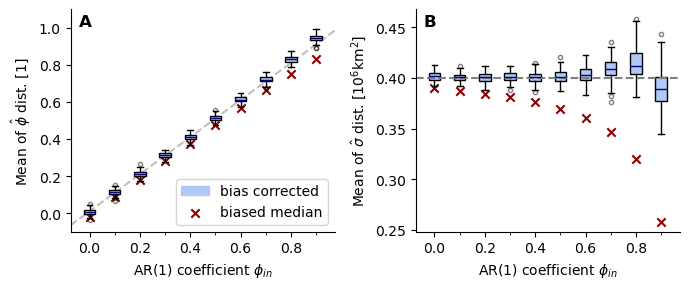

In [16]:
fig, axs, Box_Means_var, Box_Means_var_corrected, Box_Means_ar1, Box_Means_ar1_corrected = check_correction(loop_param='ar1_corrcoef', loop_values=np.arange(0.01, 1, 0.1), N=100, noise="ar1", num_members=100, amplitude=0.4)
axs[0].axline((0, 0), slope=1,color="gray",zorder=0,alpha=0.5, linestyle="--")

for ax, letter in zip(axs,["A","B"]):
    ax.text(.03, .922, letter, fontweight="bold", transform=ax.transAxes, fontsize=12, zorder=10)



import matplotlib.patches as patches


# Create a rectangle patch
rect = patches.Rectangle((50, 50), 40, 30, edgecolor='black' , color = "#B1C9F5", label = "bias corrected", alpha=1)
# Add the patch to the axis
axs[0].add_patch(rect)
axs[0].scatter([np.nan], [np.nan], marker="x", color="darkred", label=f"biased median")
axs[0].set_ylim(-0.1,1.1)


legend_elements = [Patch(color = "#B1C9F5", label = "bias corrected", alpha=1),
                   Line2D([0], [0], label=f"biased mean", color="darkred", marker="x", linestyle="")],#, linestyle="--"

lgd = axs[0].legend(loc='lower right')#, handles = legend_elements)#, bbox_to_anchor=(0.5, -0.1), ncol = 1)

hlp.save_plot(file_path=plotpath + "EM-stress-test_correction", save_plots=save_plots, file_types=["png", "pdf"])